In [10]:
import numpy as np
import os
import glob
import pandas as pd
import shutil
from tqdm import tqdm
import mdtraj as md
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:

file_path = '/data/rsg/chemistry/jyim/projects/flow-matching/notebooks/filenames.txt'
all_genie_files = []
with open(file_path, 'r') as file:
    for line in file:
        all_genie_files.append(line.strip())
all_genie_files = set(all_genie_files)

In [14]:
scope_dir = '/data/rsg/chemistry/jyim/projects/genie/data/pdbstyle-2.08'
write_dir = '/data/rsg/chemistry/jyim/large_data/scope'
all_file_paths = glob.glob(
    os.path.join(scope_dir, '**/*.ent')
)

for file_path in tqdm(all_file_paths):
    filename = os.path.basename(file_path)
    if filename.replace('.ent', '') in all_genie_files:
        write_path = os.path.join(write_dir, filename.replace('.ent', '.pdb'))
        shutil.copy(file_path, write_path)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15177/15177 [05:04<00:00, 49.77it/s]


In [17]:
metadata_path = '/data/rsg/chemistry/jyim/projects/flow-matching/preprocessed/metadata.csv'
metadata_df = pd.read_csv(metadata_path)
subset_df = metadata_df[(metadata_df.modeled_seq_len <= 128) & (metadata_df.modeled_seq_len >= 60)]

In [19]:
def compute_md_metrics(pdb_path):
    traj = md.load(pdb_path)
    pdb_ss = md.compute_dssp(traj, simplified=True)
    coil_percent = np.mean(pdb_ss == 'C')
    helix_percent = np.mean(pdb_ss == 'H')
    strand_percent = np.mean(pdb_ss == 'E')
    return coil_percent, helix_percent, strand_percent
    # return {
    #     'coil': pdb_coil_percent,
    #     'helix': pdb_helix_percent,
    #     'strand': pdb_strand_percent
    # }

In [24]:
results_df = {
    'coil': [],
    'helix': [],
    'strand': [],
    'length': [],
    'path': [],
}
for _, (path, length) in tqdm(subset_df[['raw_path', 'modeled_seq_len']].iterrows()):
    coil, helix, strand = compute_md_metrics(path)
    results_df['coil'].append(coil)
    results_df['helix'].append(helix)
    results_df['strand'].append(strand)
    results_df['length'].append(length)
    results_df['path'].append(path)
results_df = pd.DataFrame(results_df)

3673it [09:43,  6.29it/s]


In [67]:
per_length_stats = pd.pivot_table(results_df, values=['coil', 'strand', 'helix'], index=['length'], aggfunc='mean').reset_index()
melted_df = pd.melt(
    per_length_stats,
    id_vars='length', value_vars=['coil', 'helix', 'strand'], value_name='Avg Percent', var_name='Secondary structure')


<Axes: xlabel='length', ylabel='Avg Percent'>

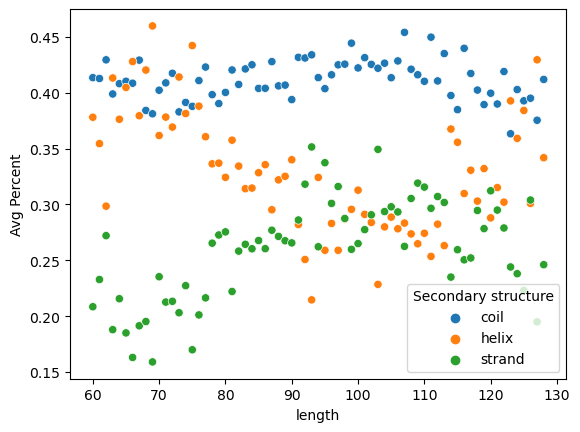

In [68]:
sns.scatterplot(data=melted_df, x='length', y='Avg Percent', hue='Secondary structure')

<Axes: xlabel='helix', ylabel='strand'>

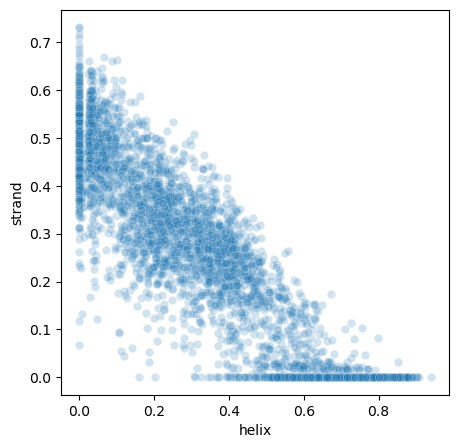

In [44]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data=results_df, x="helix", y="strand", alpha=0.2)

In [29]:
results_df.coil

count    3673.000000
mean        0.412193
std         0.113275
min         0.059524
25%         0.333333
50%         0.408333
75%         0.484848
max         0.932738
Name: coil, dtype: float64

In [31]:
results_df.helix.describe()

count    3673.000000
mean        0.321700
std         0.235546
min         0.000000
25%         0.118182
50%         0.294118
75%         0.486486
max         0.940476
Name: helix, dtype: float64

In [32]:
results_df.strand.describe()

count    3673.000000
mean        0.266032
std         0.181333
min         0.000000
25%         0.112500
50%         0.278261
75%         0.404040
max         0.731481
Name: strand, dtype: float64

In [7]:
metadata_df[metadata_df.coil_percent > 1.0]

,pdb_name,processed_path,raw_path,num_chains,quaternary_category,seq_len,modeled_seq_len,coil_percent,helix_percent,strand_percent,radius_gyration
12,d2bz2a1,/data/rsg/chemistry/jyim/projects/flow-matchin...,/data/rsg/chemistry/jyim/large_data/scope/d2bz...,1,homomer,79,79,9.050633,4.810127,6.139241,1.261660
17,d2hgca1,/data/rsg/chemistry/jyim/projects/flow-matchin...,/data/rsg/chemistry/jyim/large_data/scope/d2hg...,1,homomer,78,78,7.987179,10.038462,1.974359,1.176064
20,d2rmra_,/data/rsg/chemistry/jyim/projects/flow-matchin...,/data/rsg/chemistry/jyim/large_data/scope/d2rm...,1,homomer,71,71,7.366197,12.605634,0.028169,1.238792
30,d1v63a1,/data/rsg/chemistry/jyim/projects/flow-matchin...,/data/rsg/chemistry/jyim/large_data/scope/d1v6...,1,homomer,88,88,5.750000,14.250000,0.000000,1.760675
65,d2m80a_,/data/rsg/chemistry/jyim/projects/flow-matchin...,/data/rsg/chemistry/jyim/large_data/scope/d2m8...,1,homomer,109,109,6.972477,10.110092,2.917431,1.453158
...,...,...,...,...,...,...,...,...,...,...,...
8730,d2ldia_,/data/rsg/chemistry/jyim/projects/flow-matchin...,/data/rsg/chemistry/jyim/large_data/scope/d2ld...,1,homomer,71,71,12.507042,7.873239,9.619718,1.150923
8737,d1ixda1,/data/rsg/chemistry/jyim/projects/flow-matchin...,/data/rsg/chemistry/jyim/large_data/scope/d1ix...,1,homomer,91,91,13.098901,0.659341,6.241758,1.349767
8744,d1v5ma1,/data/rsg/chemistry/jyim/projects/flow-matchin...,/data/rsg/chemistry/jyim/large_data/scope/d1v5...,1,homomer,123,123,11.081301,2.682927,6.235772,1.502739
8750,d1wfta1,/data/rsg/chemistry/jyim/projects/flow-matchin...,/data/rsg/chemistry/jyim/large_data/scope/d1wf...,1,homomer,110,110,10.036364,0.945455,9.018182,1.477057
